In [1]:
write_figures = False


### See https://nbviewer.org/github/mlatcl/mlphysical/blob/gh-pages/_notebooks/05-01-sensitivity-analysis.ipynb



In [2]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import colors as mcolors
from matplotlib import cm
import mlai
import mlai.plot as plot

In [3]:
from emukit.test_functions.sensitivity import Ishigami

ishigami = Ishigami(a=5, b=0.1)
target_simulator = ishigami.fidelity1

In [4]:
import numpy as np
from emukit.core import ContinuousParameter, ParameterSpace
variable_domain = (-np.pi,np.pi)


space = ParameterSpace([ContinuousParameter('x1', *variable_domain),
                        ContinuousParameter('x2', *variable_domain),
                        ContinuousParameter('x3', *variable_domain)])

### Plot the non-zero components g(x)

In [5]:
x_grid = np.linspace(*variable_domain,100)
target_simulator = ishigami.fidelity1
f1 = ishigami.f1(x_grid)
f2 = ishigami.f2(x_grid)
F13 = ishigami.f13(np.array([x_grid,x_grid]).T)[:,np.newaxis]

In [6]:
from mpl_toolkits.mplot3d import Axes3D

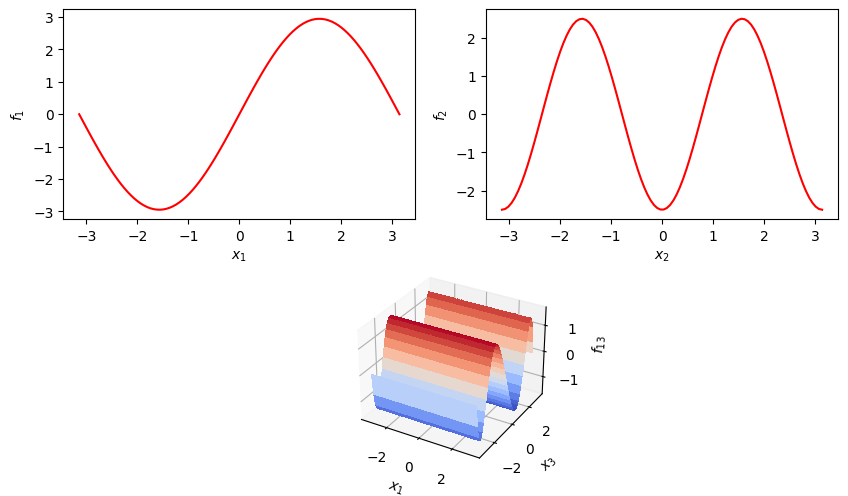

In [7]:
fig, axs = plt.subplots(2, 2, figsize=plot.big_wide_figsize)
gs = axs[1, 1].get_gridspec()
for ax in axs[1, 0:]:
    ax.remove()

ax2 = fig.add_subplot(gs[1, 0:], projection='3d')

axs[0,0].plot(x_grid, f1,'-r')
axs[0,0].set_xlabel('$x_1$')
axs[0,0].set_ylabel('$f_1$')

axs[0,1].plot(x_grid,f2,'-r')
axs[0,1].set_xlabel('$x_2$')
axs[0,1].set_ylabel('$f_2$')

X, Y = np.meshgrid(x_grid, x_grid)
surf = ax2.plot_surface(X, Y, F13, cmap=cm.coolwarm, linewidth=0, antialiased=False)

ax2.set_xlabel('$x_1$')
ax2.set_ylabel('$x_3$')
ax2.set_zlabel('$f_{13}$')

if write_figures:
    mlai.write_figure(filename='non-zero-sobol-ishigami.svg', directory='./uq')

## Total variance

In [8]:
print(ishigami.variance_total)

10.844587940719254


## First Order Sobol Indices using Monte Carlo

In [9]:
# The Ishigami function has the benefit that these 
# can be computed analytically.
ishigami.main_effects

{'x1': 0.4007425683345906, 'x2': 0.28816217057600235, 'x3': 0.0}

In [10]:
# In general, these indices need to be sampled using Monte Carlo 
# or one of the quasi-Monte Carlo methods we’ve seen in the 
# model-free experimental design

from emukit.sensitivity.monte_carlo import ModelFreeMonteCarloSensitivity


np.random.seed(10)  # for reproducibility

num_monte_carlo_points = 10000  # Number of MC samples
senstivity_ishigami = ModelFreeMonteCarloSensitivity(target_simulator, space)
main_effects, total_effects, _ = senstivity_ishigami.compute_effects(num_monte_carlo_points = num_monte_carlo_points)
print(main_effects)



{'x1': 0.4046972807643724, 'x2': 0.3009852695451654, 'x3': -0.0023884465643921227}


In [11]:
import pandas as pd

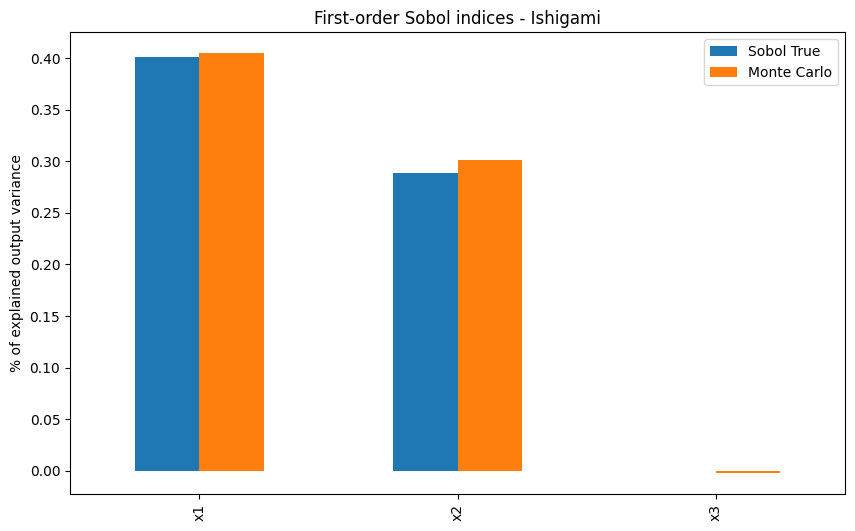

In [12]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)

d = {'Sobol True': ishigami.main_effects,
     'Monte Carlo': main_effects}

pd.DataFrame(d).plot(kind='bar', ax=ax)
ax.set_title('First-order Sobol indices - Ishigami')
ax.set_ylabel('% of explained output variance')

if write_figures:
    mlai.write_figure(filename='first-order-sobol-indices-ishigami.svg', directory='./uq')

## Total Effects Using Monte Carlo

In [13]:
# Analytically 
ishigami.total_effects

{'x1': 0.7118378294239976, 'x2': 0.28816217057600235, 'x3': 0.3110952610894071}

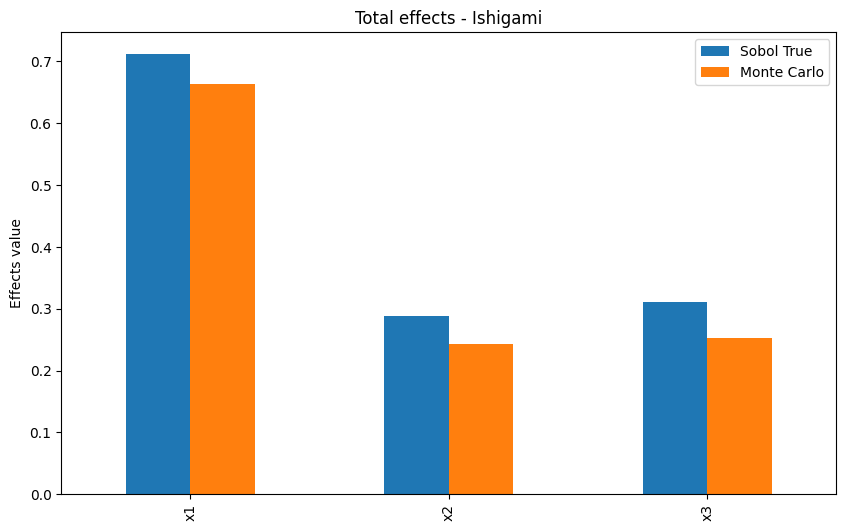

In [14]:
# Using Monte Carlo

fig, ax = plt.subplots(figsize=plot.big_wide_figsize)

d = {'Sobol True': ishigami.total_effects,
     'Monte Carlo': total_effects}

pd.DataFrame(d).plot(kind='bar', ax=ax)
ax.set_title('Total effects - Ishigami')
ax.set_ylabel('Effects value')

if write_figures:
    mlai.write_figure(filename='total-effects-ishigami.svg', directory='./uq')

In [15]:
## Computing the Sensitivity Indices Using the Output of a Model

In [16]:
# from emukit.experimental_design.model_free.random_design import RandomDesign
from emukit.core.initial_designs import RandomDesign

desing = RandomDesign(space)
X = desing.get_samples(500)
# Y  = ishigami.target_simulator(X)[:,None]
Y  = target_simulator(X)[:,np.newaxis] # FIXED


In [17]:
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper

model_gpy = GPRegression(X,Y)
model_emukit = GPyModelWrapper(model_gpy)
model_emukit.optimize()

In [18]:
from emukit.sensitivity.monte_carlo import MonteCarloSensitivity

num_mc = 10000
senstivity_ishigami_gpbased = MonteCarloSensitivity(model = model_emukit, input_domain = space)
main_effects_gp, total_effects_gp, _ = senstivity_ishigami_gpbased.compute_effects(num_monte_carlo_points = num_mc)



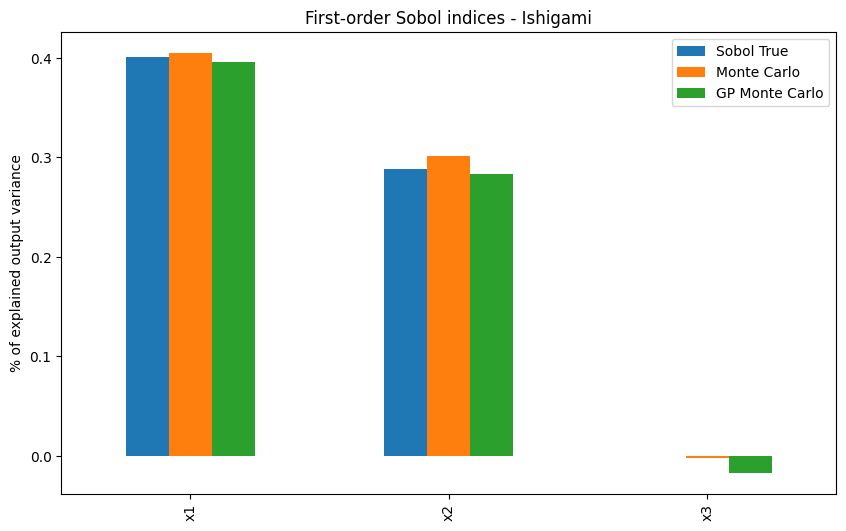

In [19]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)

main_effects_gp = {ivar: main_effects_gp[ivar][0] for ivar in main_effects_gp}

d = {'Sobol True': ishigami.main_effects,
     'Monte Carlo': main_effects,
     'GP Monte Carlo':main_effects_gp}

pd.DataFrame(d).plot(kind='bar', ax=ax)
plt.title('First-order Sobol indices - Ishigami')
plt.ylabel('% of explained output variance')

if write_figures:
    mlai.write_figure(filename='first-order-sobol-indices-gp-ishigami.svg', directory='./uq')


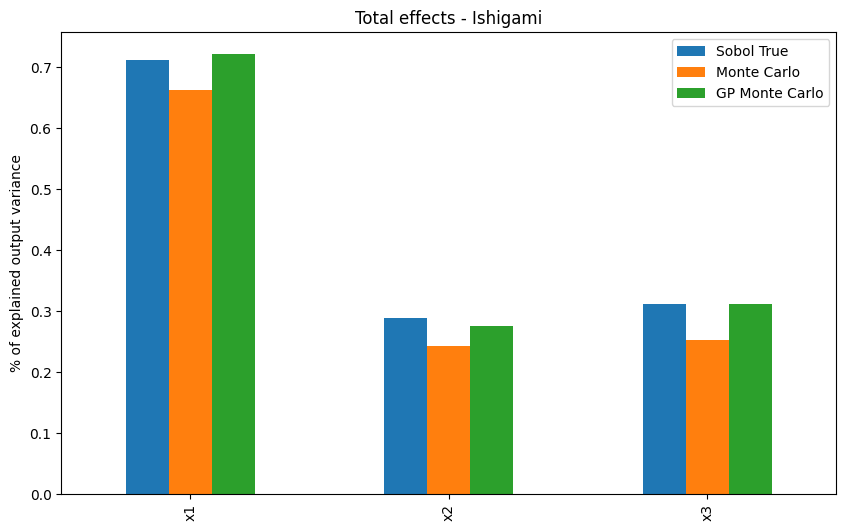

In [20]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)

total_effects_gp = {ivar: total_effects_gp[ivar][0] for ivar in total_effects_gp}

d = {'Sobol True': ishigami.total_effects,
     'Monte Carlo': total_effects,
     'GP Monte Carlo':total_effects_gp}

pd.DataFrame(d).plot(kind='bar', ax=ax)
ax.set_title('Total effects - Ishigami')
ax.set_ylabel('% of explained output variance')

if write_figures:
    mlai.write_figure(filename='total-effects-sobol-indices-gp-ishigami.svg', directory='./uq')
